# 強化学習

参考資料

- https://github.com/openai/gym/tree/master/examples/agents
- https://gym.openai.com/evaluations/eval_R3GAx3QQQpOz0G7R0AjT5g
- https://gym.openai.com/evaluations/eval_DFWdtrdSCikuZWwf8HN8A#reproducibility
- https://gym.openai.com/evaluations/eval_FlKoFCmZSiu3c2M2W54jFw

$$
\mathrm{MDP} \equiv \{\mathcal{S}, \mathcal{A}, P_{ss'}^{a}, R_{ss'}^{a}, \gamma\}
$$

$$
(s, a, r, s', a')
$$

### Q学習 (off policy method)

$$
\Delta \hat{Q}^{*}(s, a) = (r + \gamma \max_{a'} \hat{Q}^{*}(s', a'; \theta) - \hat{Q}^{*}(s, a; \theta)) \\
\hat{Q}^{*}(s, a) := \hat{Q}^{*}(s, a) + \alpha \Delta \hat{Q}^{*}(s, a)
$$

### SARSA (on policy method)

$$
\Delta \hat{Q}^{\pi}(s, a) = (r + \gamma \hat{Q}^{\pi}(s', a') - \hat{Q}^{\pi}(s, a)) \\
\hat{Q}^{\pi}(s, a) := \hat{Q}^{\pi}(s, a) + \alpha \Delta \hat{Q}^{\pi}(s, a)\\
$$


### 実装

- 状態: テーブル状の状態表現
- 学習アルゴリズム: Q学習
- 実装（変なので気をつける）: https://github.com/openai/gym/blob/master/examples/agents/tabular_q_agent.py

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

import gym
from gym import wrappers

In [2]:
# 環境の生成
#env = gym.make('CartPole-v0')
env = gym.make('FrozenLake-v0')
env.seed(42)

env = wrappers.Monitor(env, './frozenlake-v0-q-learning-softmax-01', force=True)

[2017-01-20 18:33:05,344] Making new env: FrozenLake-v0
[2017-01-20 18:33:05,375] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-20 18:33:05,376] Clearing 60 monitor files from previous run (because force=True was provided)


In [3]:
env.render()

SFFF
FHFH
FFFH
HFFG



In [4]:
def softmax(q_vector, beta=1.0):
    assert beta >= 0.0
    q_tilde = q_vector - np.max(q_vector)
    factors = np.exp(beta * q_tilde)
    return factors / np.sum(factors)

In [5]:
def select_a_with_softmax(q_vector, beta=1.0):
    prob_a = softmax(q_vector, beta=beta)
    cumsum_a = np.cumsum(prob_a)
    return np.where(np.random.rand() < cumsum_a)[0][0]

In [6]:
nb_episode = 20000

In [7]:
nb_o = env.observation_space.n
nb_a = env.action_space.n

# 状態行動価値の推定関数を初期化
q_value = np.zeros([nb_o, nb_a])
# 楽観主義的な初期化（optimistic initialization）
#q_value = 0.5 + 0.1 * np.random.randn(nb_o, nb_a) 

# 学習率 (learning rate)
alpha = 0.1

# 逆温度 (inverse temperature)
beta  = 0.
inc_beta = 250./nb_episode

# 減衰率 (discount rate)
gamma = 0.99

returns = []

In [8]:
for episode in xrange(nb_episode):

    # 報酬の初期化
    cum_r = 0
    
    # 環境を初期化し、最初の観測を得る
    curr_o = env.reset()

    # ソフトマックスによる行動選択
    curr_a = select_a_with_softmax(q_value[curr_o, :], beta)
        
    while True:
        
        # 選択された行動の実行
        next_o, reward, done, info = env.step(curr_a)
        
        # ソフトマックスによる行動選択
        next_a = select_a_with_softmax(q_value[next_o, :], beta)
        
        # Q学習 (Q learning)
        if done:
            q_target = reward
        else:
            q_target = reward + gamma * np.max(q_value[next_o, :])
                
        delta = q_target - q_value[curr_o, curr_a]
        q_value[curr_o, curr_a] += alpha * delta
        
        # 累積報酬
        cum_r = reward + gamma * cum_r
        
        # 次のステップの準備
        curr_o = next_o
        curr_a = next_a
        
        if done:
            break
            
    # 累積報酬を記録
    returns.append(cum_r)
    
    # 逆温度を上げる
    beta += inc_beta

print(np.mean(returns))

[2017-01-20 18:33:05,451] Starting new video recorder writing to /Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01/openaigym.video.0.16986.video000000.json
[2017-01-20 18:33:05,455] Starting new video recorder writing to /Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01/openaigym.video.0.16986.video000001.json
[2017-01-20 18:33:05,462] Starting new video recorder writing to /Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01/openaigym.video.0.16986.video000008.json
[2017-01-20 18:33:05,476] Starting new video recorder writing to /Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01/openaigym.video.0.16986.video000027.json
[2017-01-20 18:33:05,496] Starting new video recorder writing to /Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01/openaigym.video.0.16986.video000064.json
[2017-01-2

0.5619


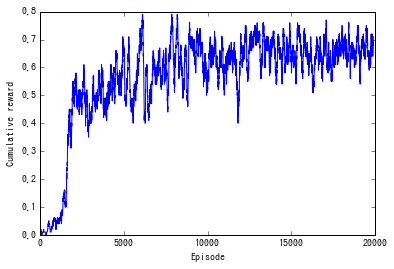

In [9]:
# 累積報酬の移動平均をプロット
window = 100
plt.plot(np.convolve(np.array(returns), np.ones((window,))/window, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')

In [10]:
q_value

array([[ 0.49536753,  0.28306389,  0.3253862 ,  0.30603388],
       [ 0.23736947,  0.2126169 ,  0.07832539,  0.44218331],
       [ 0.26584154,  0.25192499,  0.24738477,  0.39422492],
       [ 0.16508208,  0.1490744 ,  0.08265173,  0.36503404],
       [ 0.50288376,  0.13070243,  0.28335748,  0.14976063],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09749168,  0.10552296,  0.31567034,  0.03181583],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02864481,  0.15178195,  0.25645149,  0.53073308],
       [ 0.14234365,  0.57345515,  0.24320789,  0.01056084],
       [ 0.52685378,  0.27342264,  0.18821465,  0.04817685],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02334904,  0.27103502,  0.69610385,  0.20120943],
       [ 0.01180896,  0.1278077 ,  0.80324415,  0.35705058],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

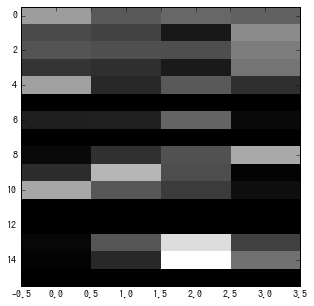

In [11]:
#q_table = np.array([agent.q[ii] for ii in range(env.observation_space.n)])

plt.figure(figsize=(5, 5))
#plt.imshow(q_value, interpolation='nearest', aspect='auto', cmap='bwr_r')
plt.imshow(q_value, interpolation='nearest', aspect='auto', cmap='gray')
#plt.clim(0.0, 1.0)

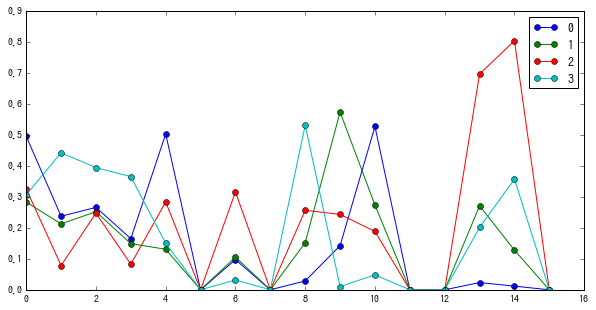

In [12]:
plt.figure(figsize=(10, 5))
#plt.imshow(q_table, interpolation='nearest', aspect='auto', cmap='bwr_r')
#plt.clim(-1.0, 1.0)
#plt.clim(0.0, 1.0)
plt.plot(q_value, 'o-');
plt.legend([0, 1, 2, 3])

- 00, 01, 02, 03
- 04, 05, 06, 07
- 08, 09, 10, 11
- 12, 13, 14, 15

In [13]:
env.render()

SFFF
FHFH
FFFH
HFFG
  (Right)


In [14]:
env.close()

[2017-01-20 18:33:33,248] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/otsuka/git/pydata.okinawa/meetup021/3_openai_gym/frozenlake-v0-q-learning-softmax-01')


In [15]:
#api_key = '********'
#gym.upload('./frozenlake-v0-q-learning-softmax-01/', api_key=api_key)